In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class SMAEMABacktester(): 
    ''' Class for the vectorized backtesting of SMA + EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA: int
        time window in days for SMA
    EMA: int
        time window in days for EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA/EMA parameters
        
    test_strategy:
        runs the backtest for the SMA/EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SAM/EMA parameters
    '''
    
    def __init__(self, symbol, SMA, EMA, start, end, tc):
        self.symbol = symbol
        self.SMA = SMA
        self.EMA = EMA
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMAEMABacktester(symbol = {}, SMA = {}, EMA = {}, start = {}, end = {})".format(self.symbol, self.SMA, self.EMA, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA"] = raw["price"].rolling(self.SMA).mean() 
        raw["EMA"] = raw["price"].ewm(span = self.EMA, min_periods = self.EMA).mean() 
        self.data = raw
        
    def set_parameters(self, SMA = None, EMA = None):
        ''' Updates SMA/EMA parameters and resp. time series.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean() 
        if EMA is not None:
            self.EMA = EMA
            self.data["EMA"] = self.data["price"].ewm(span = self.EMA, min_periods = self.EMA).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA"] > data["SMA"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        # absolute performance of the strategy
        perf = data["cstrategy"].iloc[-1] 
        # out-/underperformance of strategy
        outperf = perf - data["creturns"].iloc[-1] 
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA = {} | EMA = {} | TC = {}".format(self.symbol, self.SMA, self.EMA, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMAEMA):
        ''' Updates SMA/EMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMAEMA: tuple
            SMA/EMA parameter tuple
        '''
        self.set_parameters(int(SMAEMA[0]), int(SMAEMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA_range, EMA_range):
        ''' Finds global maximum given the SMA/EMA parameter ranges.

        Parameters
        ==========
        SMA_range, EMA_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA_range, EMA_range), finish=None)
        return opt, -self.update_and_run(opt)
    
    

In [3]:
tester = SMAEMABacktester("EURUSD=X", 50, 50, "2004-01-01", "2020-06-30", 0.0007)

In [4]:
tester.test_strategy()

(1.008877, 0.089384)

In [5]:
tester.results

,price,returns,SMA,EMA,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2004-03-11,1.235102,0.009686,1.256829,1.251285,-1,-0.009686,0.0,1.009733,0.990361
2004-03-12,1.222404,-0.010334,1.256113,1.249991,-1,0.010334,0.0,0.999352,1.000648
2004-03-15,1.227205,0.003919,1.255283,1.248975,-1,-0.003919,0.0,1.003277,0.996734
2004-03-16,1.226106,-0.000896,1.254363,1.247962,-1,0.000896,0.0,1.002379,0.997627
2004-03-17,1.222703,-0.002779,1.253535,1.246848,-1,0.002779,0.0,0.999596,1.000404
...,...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,1.101794,1.109674,1,0.002892,0.0,0.924818,1.014720
2020-06-25,1.125087,-0.005449,1.102486,1.110279,1,-0.005449,0.0,0.919793,1.009206
2020-06-26,1.122208,-0.002562,1.103213,1.110746,1,-0.002562,0.0,0.917439,1.006624


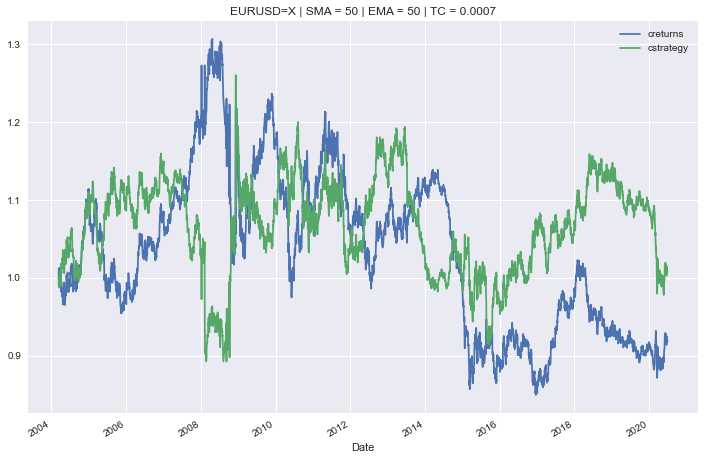

In [6]:
tester.plot_results()

In [7]:
tester.optimize_parameters((10, 100, 1), (10, 100, 1))

(array([76., 60.]), 1.71033)

In [8]:
tester.test_strategy()

(1.71033, 0.772044)

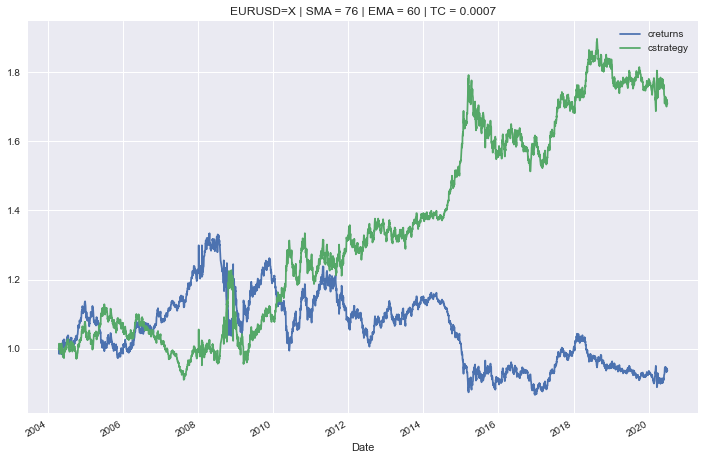

In [9]:
tester.plot_results()